<a href="https://colab.research.google.com/github/Jinyu-Luo/16-CHL5230-Datathon2/blob/main/16_CHL5230_F23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
# upload the data
from google.colab import files
uploaded = files.upload()

Saving Mortality.csv to Mortality.csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['Mortality.csv']))
data = df # make a copy of the dataset
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


The dataset contains the following attributes:

*   **age**: Age of the patient.
*   **anaemia**: A binary indicator (0 for No, 1 for Yes) suggesting if the patient has anemia.
*   **creatinine_phosphokinase**: Level of the CPK enzyme in the blood (mcg/L). An increased amount can be indicative of damage to the heart or other muscles.
*   **diabetes**: A binary indicator (0 for No, 1 for Yes) suggesting if the patient has diabetes.
*   **ejection_fraction**: Percentage of blood leaving the heart at each contraction. A typical range is between 50% and 70%. Lower percentages may indicate heart failure.
*   **high_blood_pressure**: A binary indicator (0 for No, 1 for Yes) suggesting if the patient has high blood pressure or hypertension.
*   **platelets**: Platelets in the blood (kiloplatelets/mL). They are tiny blood cells that help the body form clots to stop bleeding.
*   **serum_creatinine**: Level of serum creatinine in the blood (mg/dL). It measures kidney function, and higher levels might indicate poorer kidney function.
*   **serum_sodium**: Level of serum sodium in the blood (mEq/L). It's an essential electrolyte that helps regulate water balance, pH, and nerve signals.
*   **sex**: Binary indicator (1 for Male, 0 for Female).
*   **smoking**: A binary indicator (0 for No, 1 for Yes) suggesting if the patient smokes or not.
*   **time**: This seems like some form of time indicator. It could be the duration of observation/follow-up (e.g., days from initial measurement).
*   **DEATH_EVENT**: The target variable, a binary indicator (0 for No, 1 for Yes) suggesting if the patient died from a cardiovascular complication.
**Research Objective**:

Given the attributes in the dataset, our group aims to understand cardiovascular complications and their outcomes. Specifically, we are interested in:

1. Identify how various features predict mortality.

2. Explore the changes in the duration until a death event.

3. How does the feature importance to mortality differ between reversible and non-reversible patient attributes?

Research Question:

Which patient characteristics are most predictive of cardiovascular mortality within the observed timeframe, and how accurately can we classify the risk of mortality based on these attributes in this dataset?

## Data Exploration

Frist, print the summary statistics to understand the distribution of the data.

In [4]:
description = data.describe()
description

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


- The age range of the patients is between 40 to 95 years, with a median of 60.

- 65% of the patients are males

- The CPK enzyme value has a minimum of 23 and a maximum of 7861. The standard deviation is quite large, suggesting a high variability in this feature. The majority have a value below 582, and those extreme values might be skewing the mean.

- The ejection fraction ranges from 14 to 80, and its mean and median are quite close, suggesting a relatively normal distribution.

#### Check Missing Values

In [7]:
# Check the number of missing values for each column
missing_values = data.isnull().sum()

# Print the columns with missing values and their count
print(missing_values[missing_values > 0])

Series([], dtype: int64)


No missing value is detected.

#### Categorical Variables

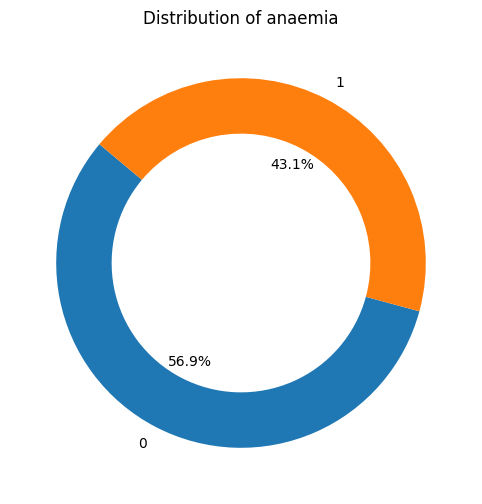

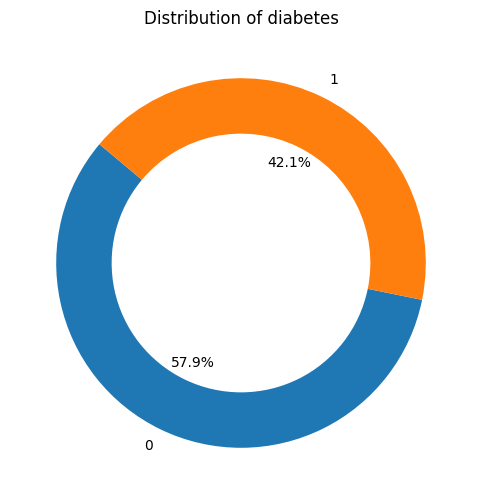

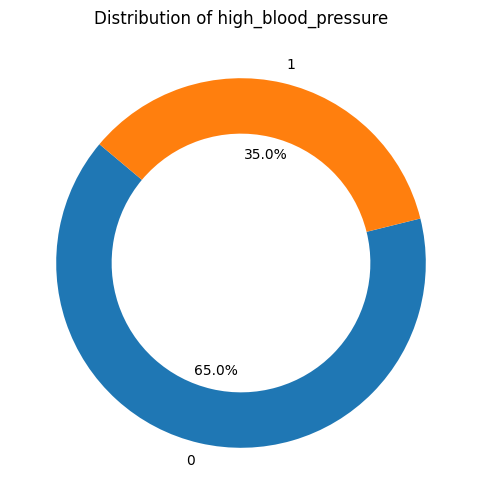

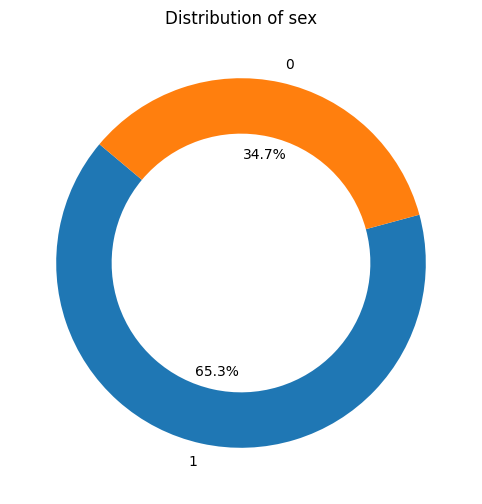

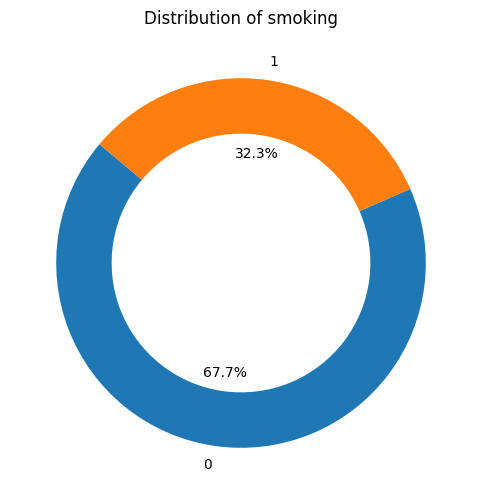

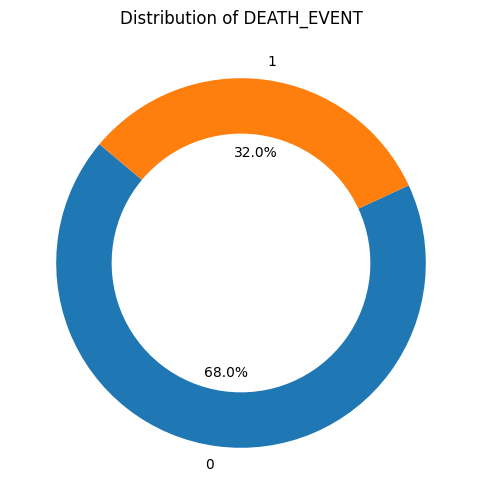

In [13]:
categoricals = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']
for col in categoricals:
  # get the count of each category
  counts = data[col].value_counts()

  # plot
  plt.figure(figsize = (8, 6))
  plt.pie(counts, labels = counts.index, autopct = '%1.1f%%',
          startangle = 140, wedgeprops = dict(width = 0.3))
  plt.title(f'Distribution of {col}')
  plt.show()

**Observation**:

- Among the participants, 43.1% of the patients suffer from anaemia, while 41.8% have been diagnosed with diabetes. A significant 64.9% of the patients do not exhibit high blood pressure. In terms of demographics, females comprises 35.1% of the cohort, and 32.1% of the population currently smoke. Lastly, 32.1% experienced a death event within the observed time period.

#### Numerical Variables

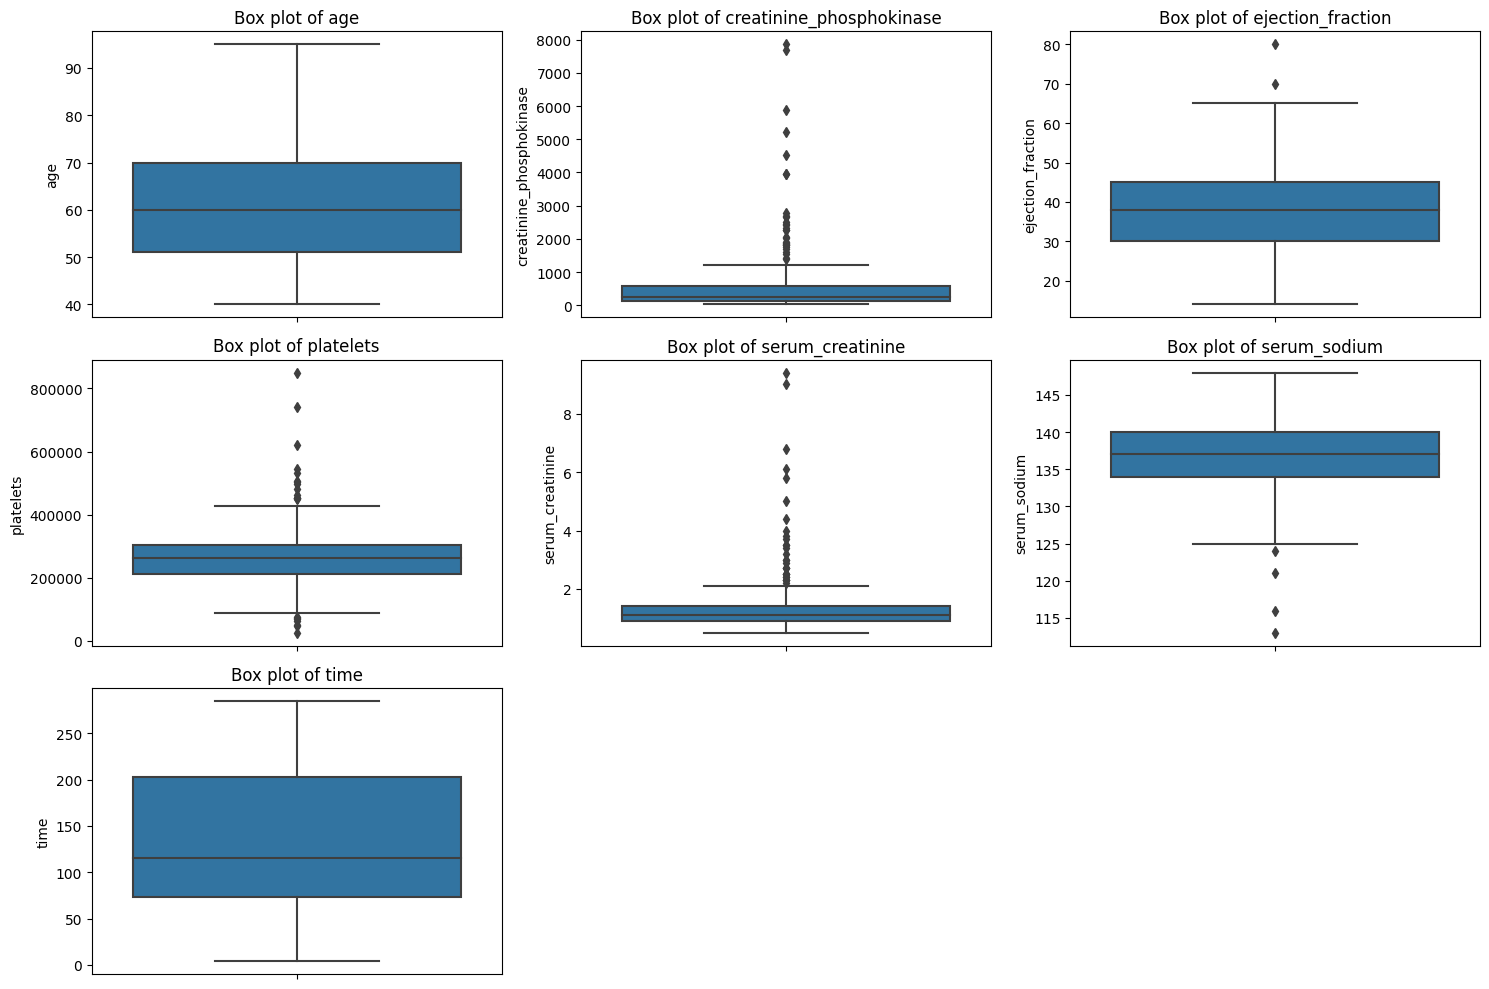

In [6]:
numerical = description.drop('count')
numerical= description.drop(['anaemia','diabetes', 'high_blood_pressure',
                               'sex', 'smoking', 'DEATH_EVENT'], axis = 1)

# Visualize the summary statistics
plt.figure(figsize = (15, 10))
for i, feature in enumerate(numerical, 1):
    plt.subplot(3, 3, i)  # Adjust subplot dimensions based on the number of features
    sns.boxplot(y=df[feature])
    plt.title(f'Box plot of {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

**Observations**:

- Except age and time, outliers are observed in the rest numerical variables.

- Note that only two outliers were detected in Ejection Fraction, so we can consider to remove this two observations first.

- Extremely high values in Creatinine Phosphokinase and Serum Creatinine could be indicative of certain medical conditions. We can consider use log transformation to address those outliers.

  - Elevated levels of serum creatinine can indicate impaired kidney function or kidney disease.

  - High CPK values can indicate muscles damage, including heart attacks.

- Since outliers in Platelets are on both sides, we can consider to use Interquartile Range to scale the data, as it is less sensitive to outliers than standard scaling methods.

- Lots of low values shown up on the box plot of serum sodium, which might be clinically significant. We might consider to use robust scaling or winsorizing to address these outliers.

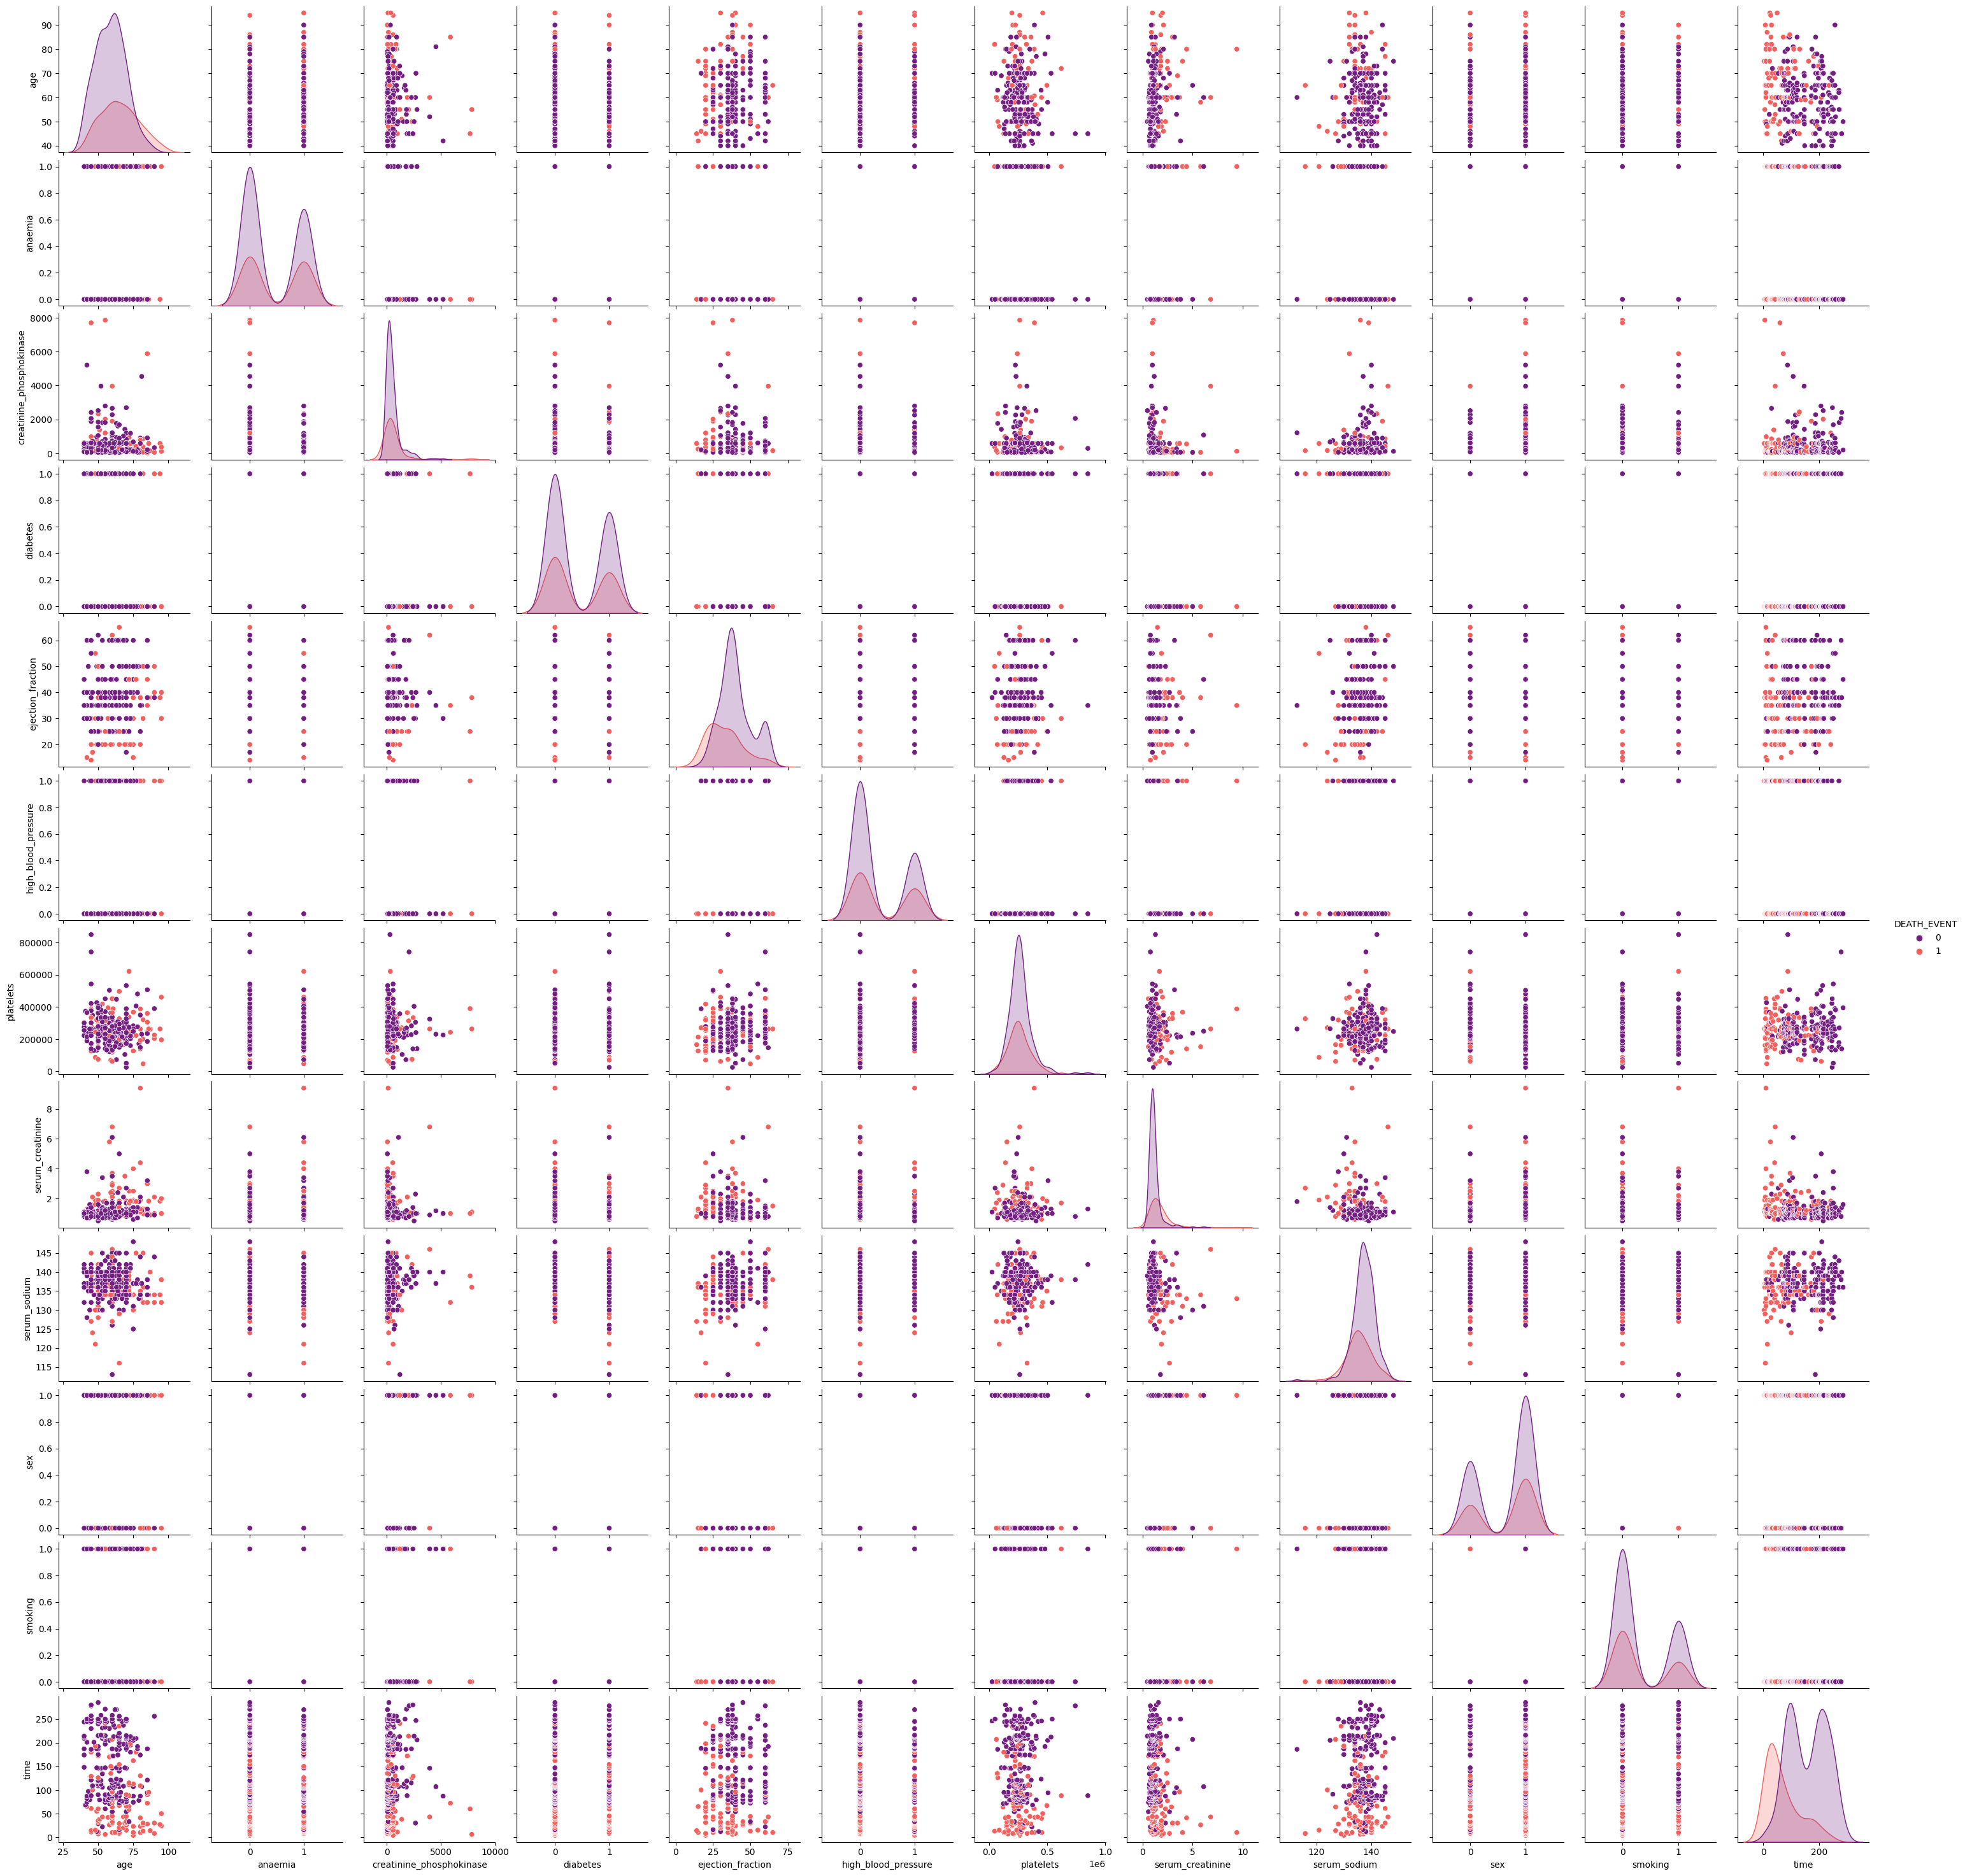

In [18]:
# Display pair plot for data visualization
sns.pairplot(data, hue = 'DEATH_EVENT', palette = 'magma')
plt.show()

### Feature Engineering

First, remove outliers from ejection fraction

In [10]:
# Calculate Interquartile Range
Q1 = data['ejection_fraction'].quantile(0.25)
Q3 = data['ejection_fraction'].quantile(0.75)
IQR = Q3-Q1

# Filter out the outliers
data = data[~((data['ejection_fraction'] < (Q1 - 1.5 * IQR)) |
              (data['ejection_fraction'] > (Q3 + 1.5 * IQR)))]

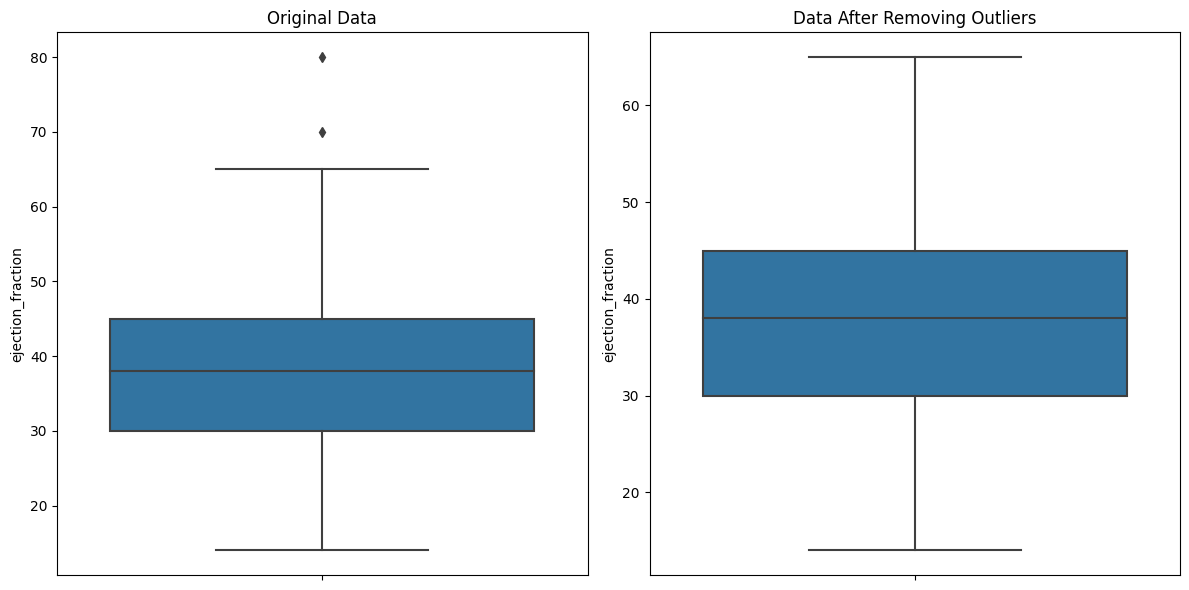

In [16]:
plt.figure(figsize=(12, 6))

# Original data
plt.subplot(1, 2, 1)
sns.boxplot(y=df['ejection_fraction'])
plt.title('Original Data')

# Data after removing outliers
plt.subplot(1, 2, 2)
sns.boxplot(y=data['ejection_fraction'])
plt.title('Data After Removing Outliers')

plt.tight_layout()
plt.show()

## Linear Regression

## Logistic Regression

### Data Preparation

In [19]:
# Split the data into features and target variable
X = data.drop('DEATH_EVENT', axis = 1)
y = data['DEATH_EVENT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

# Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Build the Logistic Regression Model

In [20]:
# Train logistic regression model
log_reg = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'liblinear')
log_reg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [21]:
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[36  4]
 [ 6 14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        40
           1       0.78      0.70      0.74        20

    accuracy                           0.83        60
   macro avg       0.82      0.80      0.81        60
weighted avg       0.83      0.83      0.83        60



### Result Visualization

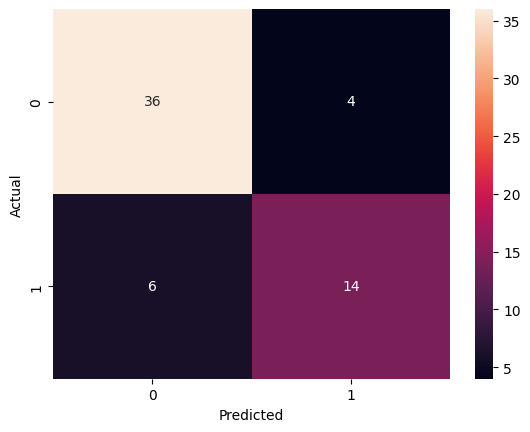

In [22]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### Further Exploration of the Features

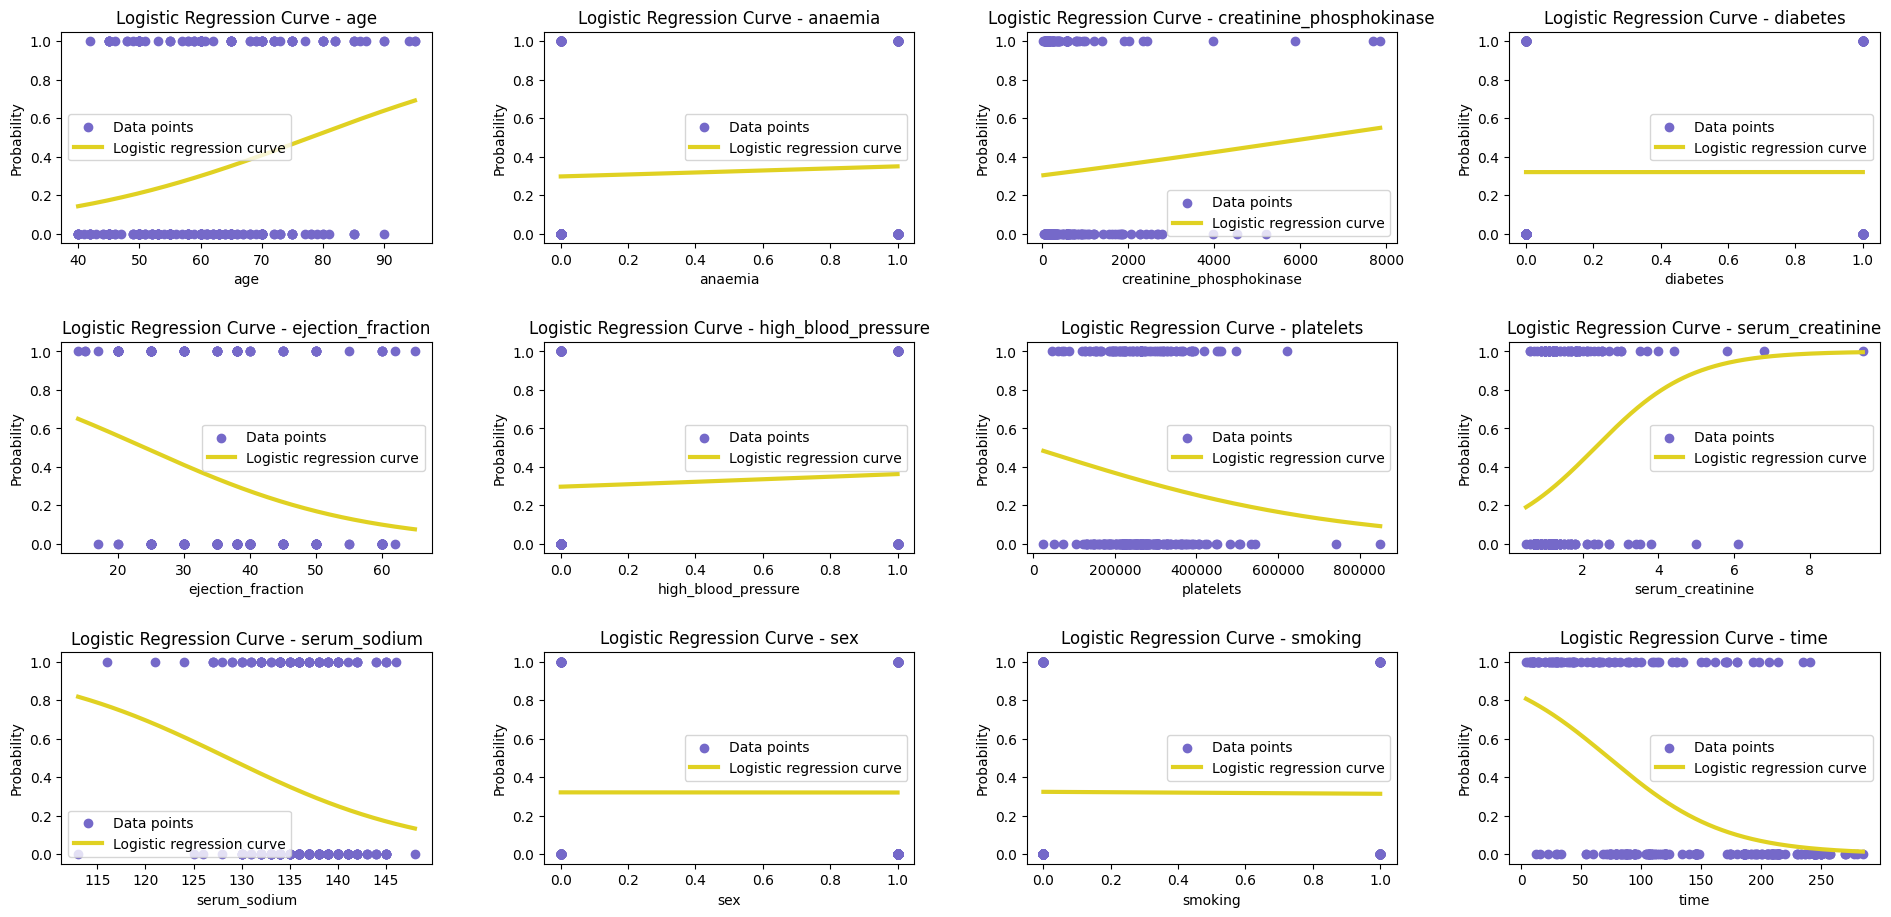

In [25]:
# Create logistic regression object
log_reg = LogisticRegression()

fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.tight_layout(pad=5.0)  # Adds padding between subplots

for i, feature in enumerate(data.columns[:-1]):  # Exclude 'Outcome' column
    row = i // 4  # Determine row index
    col = i % 4   # Determine column index

    # Reshape the feature and outcome arrays to fit the model
    X = data[[feature]]
    y = data['DEATH_EVENT']

    # Fit logistic regression model
    log_reg.fit(X, y)

    # Get min and max values of the feature for plotting
    x_test = np.linspace(X.min(), X.max(), 300)

    # Get the probability for each value in the range
    prob = log_reg.predict_proba(x_test)[:, 1]

    # Plot the data points
    axs[row, col].scatter(X, y, color='#7569c9', label='Data points')

    # Plot the sigmoid curve
    axs[row, col].plot(x_test, prob, color='#e0d122', lw=3, label='Logistic regression curve' )

    axs[row, col].set_title(f'Logistic Regression Curve - {feature}')
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Probability')
    axs[row, col].legend()

plt.show()

### Logistic Regression Model Summary

In [24]:
import statsmodels.api as sm

# Separate features and target variable
X = data.drop('DEATH_EVENT', axis=1)
y = data['DEATH_EVENT']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.365073
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            DEATH_EVENT   No. Observations:                  297
Model:                          Logit   Df Residuals:                      284
Method:                           MLE   Df Model:                           12
Date:                Sun, 01 Oct 2023   Pseudo R-squ.:                  0.4175
Time:                        14:26:44   Log-Likelihood:                -108.43
converged:                       True   LL-Null:                       -186.15
Covariance Type:            nonrobust   LLR p-value:                 4.438e-27
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       11.4195      5.699      2.004      0.045       0.250

# Reference

[1] Rexrode, K. M., Madsen, T. E., Yu, A. Y.X., Carcel, C., Lichtman, J. H., & Miller, E. C. (2022). The Impact of Sex and Gender on Stroke. Circulation Research, 130(4), 512-528. https://doi.org/10.1161/CIRCRESAHA.121.319915

